In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import io
import os
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/movies/5000_movies.csv'

Mounted at /content/drive


In [2]:
import ast
df = pd.read_csv(save_path)
df['genres'] = df['genres'].apply(ast.literal_eval)

In [3]:
len(df)

39906

In [4]:
pip install transformers


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel


In [6]:

# Encode genres
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'].apply(eval if isinstance(df['genres'].iloc[0], str) else lambda x: x))

# Prepare plots
texts = df['description'].tolist()

# Train-validation split
texts_train, texts_val, y_train, y_val = train_test_split(texts, y, test_size=0.2, random_state=42)


In [7]:
# Use BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def encode(text, tokenizer, max_len=512):
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    return encoding['input_ids'].squeeze(0)  # shape: (max_len,)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
class MovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = encode(text, self.tokenizer, self.max_len)
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(label, dtype=torch.float)


In [9]:
train_dataset = MovieDataset(texts_train, y_train, tokenizer)
val_dataset = MovieDataset(texts_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the pretrained BERT model
bert_model = AutoModel.from_pretrained('bert-base-uncased')

# grab the token embeddings
pretrained_embeddings = bert_model.embeddings.word_embeddings.weight.data



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
class LSTMGenreClassifier(nn.Module):
    def __init__(self, pretrained_embeddings, hidden_dim, num_labels, num_layers=1, bidirectional=True):
        super(LSTMGenreClassifier, self).__init__()
        vocab_size, embed_dim = pretrained_embeddings.shape

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight = nn.Parameter(pretrained_embeddings)  # use BERT embeddings
        self.embedding.weight.requires_grad = False  # (Optional) freeze embeddings

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.3)
        direction_factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * direction_factor, num_labels)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        x = self.dropout(hidden)
        output = torch.sigmoid(self.fc(x))
        return output


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMGenreClassifier(
    pretrained_embeddings=pretrained_embeddings,
    hidden_dim=256,
    num_labels=y.shape[1],
    num_layers=2,
    bidirectional=True
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)


In [12]:
train_losses = []
val_accuracies = []

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # shape: (batch_size, num_labels)

            top1_preds = torch.argmax(outputs, dim=1)  # shape: (batch_size,)

            for pred, true_labels in zip(top1_preds, labels):
                if true_labels[int(pred)] == 1:
                    correct += 1
                total += 1

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Val Top-1 Accuracy: {val_accuracy:.4f}")


<ipython-input-8-2023a1b2e20a>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_ids, dtype=torch.long), torch.tensor(label, dtype=torch.float)


Epoch 1/30 - Loss: 0.3889 - Val Top-1 Accuracy: 0.2275
Epoch 2/30 - Loss: 0.3555 - Val Top-1 Accuracy: 0.3949
Epoch 3/30 - Loss: 0.3249 - Val Top-1 Accuracy: 0.4652
Epoch 4/30 - Loss: 0.3160 - Val Top-1 Accuracy: 0.4681
Epoch 5/30 - Loss: 0.3090 - Val Top-1 Accuracy: 0.4901
Epoch 6/30 - Loss: 0.3034 - Val Top-1 Accuracy: 0.4970
Epoch 7/30 - Loss: 0.2992 - Val Top-1 Accuracy: 0.5228
Epoch 8/30 - Loss: 0.2959 - Val Top-1 Accuracy: 0.5279
Epoch 9/30 - Loss: 0.2919 - Val Top-1 Accuracy: 0.5484
Epoch 10/30 - Loss: 0.2885 - Val Top-1 Accuracy: 0.5236
Epoch 11/30 - Loss: 0.2858 - Val Top-1 Accuracy: 0.5474
Epoch 12/30 - Loss: 0.2831 - Val Top-1 Accuracy: 0.5547
Epoch 13/30 - Loss: 0.2802 - Val Top-1 Accuracy: 0.5673
Epoch 14/30 - Loss: 0.2778 - Val Top-1 Accuracy: 0.5641
Epoch 15/30 - Loss: 0.2755 - Val Top-1 Accuracy: 0.5588
Epoch 16/30 - Loss: 0.2724 - Val Top-1 Accuracy: 0.5757
Epoch 17/30 - Loss: 0.2696 - Val Top-1 Accuracy: 0.5675
Epoch 18/30 - Loss: 0.2670 - Val Top-1 Accuracy: 0.5616
E

In [ ]:
model.eval()
top1_correct = 0
total_samples = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # shape: (batch_size, num_labels)

        top1_preds = torch.argmax(outputs, dim=1)  # index of top-1 predicted genre

        for pred, true_labels in zip(top1_preds, labels):
            if true_labels[int(pred)] == 1:  # if top prediction exists in true labels
                top1_correct += 1
            total_samples += 1

        # (optional) Save preds and labels for precision/recall/f1
        all_preds.append((outputs > 0.5).int().cpu())
        all_labels.append(labels.cpu())

# Top-1 Accuracy
top1_accuracy = top1_correct / total_samples
print(f"Top-1 Accuracy: {top1_accuracy:.4f}")


<ipython-input-8-2023a1b2e20a>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_ids, dtype=torch.long), torch.tensor(label, dtype=torch.float)


Top-1 Accuracy: 0.5541


In [ ]:
# Stack all predictions and labels
all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
f1 = f1_score(all_labels, all_preds, average='micro')

print(f"Precision (micro): {precision:.4f}")
print(f"Recall (micro): {recall:.4f}")
print(f"F1 Score (micro): {f1:.4f}")


Precision (micro): 0.5040
Recall (micro): 0.4044
F1 Score (micro): 0.4488


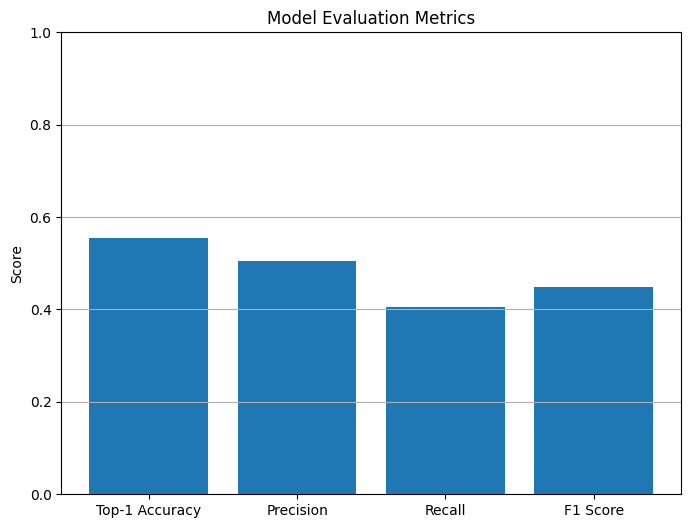

In [ ]:
import matplotlib.pyplot as plt

# Now plot Top-1 accuracy along with others
metrics = ['Top-1 Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [top1_accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()
